In [1]:
par_log_transform = True

In [2]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import matplotlib.colors as colors
from utils.my_plotting_lib import plotBarcodes, plotConfidenceEllipse, labelAxes
from textwrap import fill
rc('text', usetex=True)

In [3]:
labels = {
        'exact': f'smFISH exact',
        'binomial': f'smFISH missing spots (uniform rate)',
        'binomial_state_dep': f'smFISH missing spots (varying rate)',
        'flowcyt': f'Integrated fluorescence intensity',
        'poisson': f'Additive Poisson noise',
        'binomial_poisson': f'Missing spots + Additive Poisson'
}

colors = {
        'exact': f'red',
        'binomial': f'blue',
        'binomial_poisson': 'k',
        'binomial_state_dep': f'brown',
        'poisson': 'orange',
        'flowcyt': f'darkgreen'
}

with np.load('results/fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('results/bursting_parameters.npz') as par:
    kon = par['kon']
    koff = par['koff']
    alpha = par['alpha']
    gamma = par['gamma']

theta = np.array([kon, koff, alpha, gamma])

measurement_methods = ['exact', 'binomial', 'binomial_state_dep', 'flowcyt', 'poisson', 'binomial_poisson']

## D-optimal sampling periods for different types of measurements

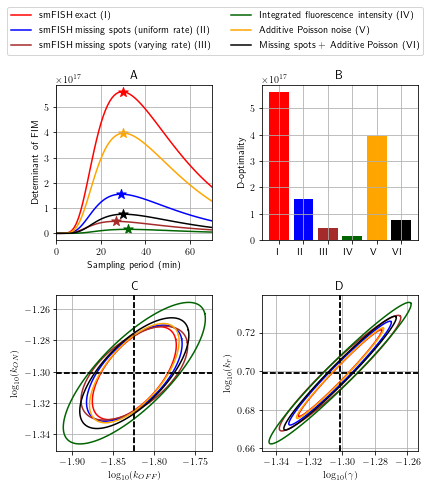

In [4]:
with np.load("results/opt_sampling_periods.npz", allow_pickle=True) as _:
    opt_rates = _["opt_rates"][()]
    fim_multi_cells_times = _["fim_multi_cells_times"][()]
    det_fim_multi_cells_times = _["det_fim_multi_cells_times"][()]

roman_numerics = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X']

DT_MAX = 70
fig, axs = plt.subplots(2,2)
fig.set_size_inches(6, 6)
fig.set_tight_layout(True)
for im, meas in enumerate(measurement_methods):
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]
    dt_array = np.linspace(0, len(dets)-1, len(dets))
    
    axs[0,0].plot(dt_array, dets, label=f"{labels[meas]} ({roman_numerics[im]})", color=colors[meas])
    axs[0,0].scatter(dt_array[idx_opt],
                   dets[idx_opt],
               100,
               color=colors[meas],
                   marker='*')

    axs[0,1].bar(im, dets[idx_opt], color=colors[meas])

    plotConfidenceEllipse(fims[idx_opt],
                      3,
                      axs[1,0],
                      [1,0],
                      np.log10(theta),
                      colors[meas], '')
    plotConfidenceEllipse(fims[idx_opt],
                      3,
                      axs[1,1],
                      [3,2],
                      np.log10(theta), colors[meas], '')

h, l = axs[0,0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 1), loc='lower center', ncol=2)
axs[0, 0].set_xlim([0, DT_MAX])
axs[0, 0].set_xlabel('Sampling period (min)')
axs[0, 0].set_ylabel('Determinant of FIM')

axs[0, 1].set_ylabel('D-optimality')
axs[0, 1].set_xticks(range(len(measurement_methods)))
axs[0, 1].set_xticklabels(roman_numerics[:len(measurement_methods)], ha='right')

axs[1,0].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1,0].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[1,1].set_ylabel('$\log_{10}({k_{r}})$')
axs[1,1].set_xlabel('$\log_{10}({\gamma})$')

for ax in list(axs.flatten()):
    ax.grid(True)
labelAxes(axs)
fig.savefig('figs/bursting_fim_dopt.pdf', bbox_inches='tight')

In [5]:
import pandas as pd

lst = []
for design in measurement_methods:
    dt_opt = opt_rates[design]
    d_opt = det_fim_multi_cells_times[design][dt_opt]
    lst.append(
        [labels[design],
        dt_opt,
        d_opt]
    )
df = pd.DataFrame(lst, columns=['Design', 'Optimal sampling period (minute)', 'D-optimal information'])
df.to_csv("tables/bursting_designs.csv", index=False, float_format="%.2e")

## Optimal combination of Poisson-additive and random spot-missing measurements

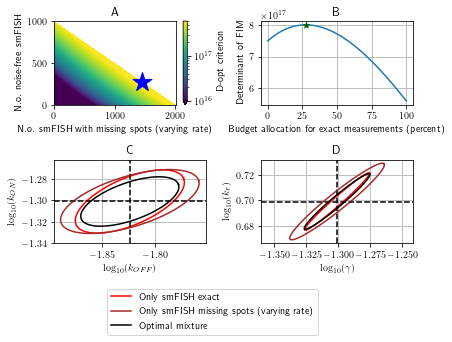

In [6]:
import matplotlib.colors as Colors
import matplotlib.gridspec as gridspec

with np.load("results/opt_mixture.npz", allow_pickle=True) as _:
         opt_mixture=_["opt_mixture"]
         obj_values=_["obj_values"]
         fim_mix_opt=_["fim_mix_opt"]

# Extract the diagonal element
det_fim_diagonal = np.array([obj_values[i, 2000 - 2*i] for i in range(1001)])

fig = plt.figure(figsize=(6, 4), tight_layout=True)
gs = gridspec.GridSpec(2, 2, figure=fig)

axs = fig.subplots(2, 2).flatten()


mixture_plot = axs[0].pcolorfast(obj_values, norm=Colors.LogNorm(vmin=1.0E16, vmax=6E17))
fig.colorbar(mixture_plot, ax=axs[0], orientation='vertical', extend='min',
             label=r"D-opt criterion")
axs[0].scatter(opt_mixture[1], opt_mixture[0], 400, marker='*', color="blue")
axs[0].set_xlabel("N.o. smFISH with missing spots (varying rate)")
axs[0].set_ylabel("N.o. noise-free smFISH")

axs[1].grid()
axs[1].plot(100.0*np.arange(1001)/1000.0, det_fim_diagonal)
axs[1].scatter(100.0*opt_mixture[0]/1000.0, det_fim_diagonal[opt_mixture[0]], marker='*', color="darkgreen", zorder=2)
axs[1].set_xlabel("Budget allocation for exact measurements (percent)")
axs[1].set_ylabel("Determinant of FIM")

for meas in ['exact', 'binomial_state_dep']:
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]

    plotConfidenceEllipse(fims[idx_opt],
                      3,
                      axs[2],
                      [1,0],
                      np.log10(theta),
                      colors[meas], f'Only {labels[meas]}')
    plotConfidenceEllipse(fims[idx_opt],
                      3,
                      axs[3],
                      [3,2],
                      np.log10(theta), colors[meas], f'Only {meas}')
plotConfidenceEllipse(fim_mix_opt,
                      3,
                      axs[2],
                      [1,0],
                      np.log10(theta),
                      'k', 'Optimal mixture')
plotConfidenceEllipse(fim_mix_opt,
                  3,
                  axs[3],
                  [3,2],
                  np.log10(theta), 'k', 'Optimal mixture')

h, l = axs[2].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, -1, 1, 1), loc='upper center', ncol=1)

for j in range(2, 4):
    axs[j].set_aspect('equal', 'datalim')
    axs[j].grid()
axs[2].set_ylabel('$\log_{10}({k_{ON}})$')
axs[2].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[3].set_ylabel('$\log_{10}({k_{r}})$')
axs[3].set_xlabel('$\log_{10}({\gamma})$')
labelAxes(axs)
fig.savefig("figs/bursting_mixture_dopt.png", dpi=300, bbox_inches="tight")

## Heatmaps for the probability kernels

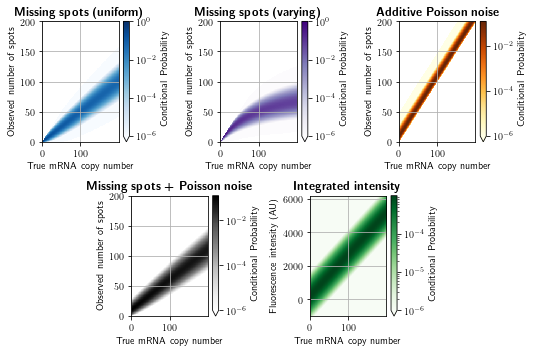

In [7]:
pdos = {}
yranges = {}
for s in ["binomial", "binomial_state_dep", "poisson", "binomial_poisson", "flowcyt"]:
    with np.load(f'results/distortion_matrix_{s}.npz') as data:
        pdos[s] = data['C']
        yranges[s] = data['yrange']
pdo_colors = ["Blues",  "Purples", "YlOrBr", "Greys", "Greens"]

fig = plt.figure(figsize=(7.5, 5), tight_layout=True)
axs = list(fig.subplot_mosaic("""
                        AABBCC
                        .DDEE.
                        """).values())

for i,s in enumerate(pdos.keys()):
    C = pdos[s][:, :200]
    p = axs[i].pcolorfast(range(0,200), yranges[s], C, norm=Colors.LogNorm(vmin=1.0E-6),
                         cmap=plt.cm.get_cmap(pdo_colors[i]))
    fig.colorbar(p, ax=axs[i], orientation='vertical', extend='min', label=r"Conditional Probability")

for j in range(0,4):
    axs[j].set_xlabel('True mRNA copy number')
    axs[j].set_ylabel('Observed number of spots')
    axs[j].set_ylim([0, 200])
axs[4].set_xlabel('True mRNA copy number')
axs[4].set_ylabel('Fluorescence intensity (AU)')

models = ['Missing spots (uniform)',
          'Missing spots (varying)',
          "Additive Poisson noise",
          'Missing spots + Poisson noise',
          'Integrated intensity']
for j in range(len(models)):
    axs[j].set_title(rf'\textbf{{{models[j]}}}', ha='center')
    axs[j].grid()
fig.savefig('figs/bursting_kernel_maps.png', bbox_inches='tight', dpi=200)

## MLE validation for binomial noise model with varying rate


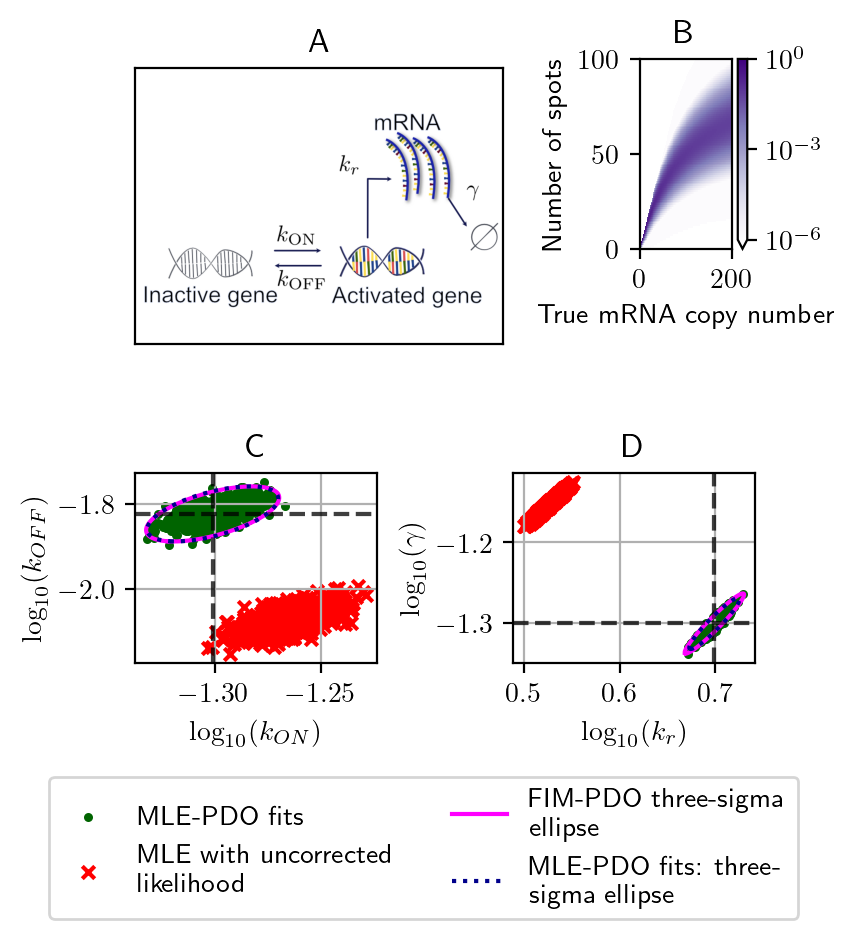

In [8]:
with np.load("results/ge_mle_fits.npz") as _:
    exact_data_fits = _["fits_correct"]
    distorted_data_fits = _["fits_incorrect"]

fig = plt.figure(figsize=(4, 4), dpi=200)
axs = list(fig.subplot_mosaic(
"""
AAAAAA..BB
AAAAAA..BB
AAAAAA....
..........
CCCC..DDDD
CCCC..DDDD
"""
).values())

# axs[0].axis("off")
bursting_schematic = plt.imread("figs/bursting_schematic.png")
axs[0].imshow(bursting_schematic)
axs[0].set_xticks([])
axs[0].set_yticks([])

C = pdos["binomial_state_dep"][:, :200]
p = axs[1].pcolorfast(C, norm=Colors.LogNorm(vmin=1.0E-6),
                         cmap=plt.cm.get_cmap(pdo_colors[1]))
fig.colorbar(p, ax=axs[1], orientation='vertical', extend='min', label="")
axs[1].set_xlabel('True mRNA copy number')
axs[1].set_ylabel('Number of spots')
axs[1].set_ylim([0, 100])

sample_cov_correct = np.cov(exact_data_fits, rowvar=False)
for i, pair in enumerate([[0, 1], [2, 3]]):
    axs[2+i].grid(True)

    axs[2+i].scatter(exact_data_fits[:, pair[0]], exact_data_fits[:, pair[1]], 5, color="darkgreen", label="MLE-PDO fits")
    axs[2+i].scatter(distorted_data_fits[:, pair[0]], distorted_data_fits[:, pair[1]], 20, color="red", label="MLE with uncorrected likelihood", marker="x")

    plotConfidenceEllipse(fim_multi_cells_times["binomial_state_dep"][30],
                  3,
                  axs[2+i],
                  [pair[0],pair[1]],
                  np.log10(theta),
                  "magenta", 'FIM-PDO three-sigma ellipse')


    plotConfidenceEllipse(np.linalg.inv(sample_cov_correct),
                  3,
                  axs[2+i],
                  [pair[0],pair[1]],
                  np.log10(theta),
                  "darkblue", 'MLE-PDO fits: three-sigma ellipse', ':')

axs[2].set_xlabel('$\log_{10}({k_{ON}})$')
axs[2].set_ylabel('$\log_{10}({k_{OFF}})$')
axs[3].set_xlabel('$\log_{10}({k_{r}})$')
axs[3].set_ylabel('$\log_{10}({\gamma})$')

labelAxes(axs)

h, l = axs[3].get_legend_handles_labels()
l = [fill(label, 20) for label in l]
fig.legend(h, l, bbox_to_anchor=(0, -1, 1, 1), loc="upper left", ncol=2)
fig.savefig("figs/bursting_mle.png", dpi=300, bbox_inches="tight")

## Binomial distortion operator: more extensive sweep over different distortion levels

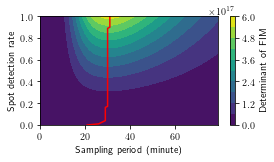

In [31]:
from matplotlib.colors import LogNorm

with np.load("results/binomial_sweep.npz") as _:
    dtOpts = _["dtOpts"]
    detectionRateGrid = _["detectionRateGrid"]
    dtMax = _["dtMax"][()]
    fimDets = _["fimDets"]

fig = plt.figure()
fig.set_size_inches(4,2)
ax = fig.add_subplot()
cp = ax.contourf(range(dtMax), detectionRateGrid, np.abs(fimDets), 10)
fig.colorbar(cp, label="Determinant of FIM")
ax.plot(dtOpts, detectionRateGrid, color="red")
ax.set_xlabel("Sampling period (minute)")
ax.set_ylabel("Spot detection rate")
fig.savefig("figs/bursting_binomial_sweep.png", dpi=300, bbox_inches="tight")

## Effect of binning

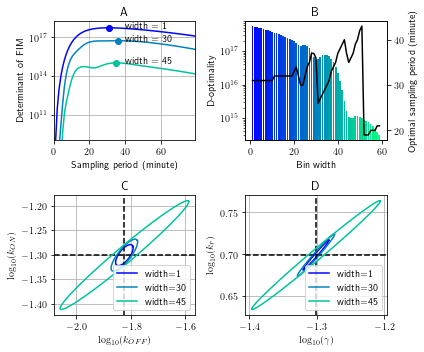

In [10]:
with np.load("results/binning_sweep.npz", allow_pickle=True) as _:
    dtOpts = _["dtOpts"]
    binWidths = _["binWidths"]
    dtMax = _["dtMax"][()]
    fimDets = _["fimDets"]
    optimalFims = _["optimalFims"][()]

fig, axs = plt.subplots(2,2)
fig.set_tight_layout(True)
fig.set_size_inches(6, 5)
cm = plt.cm.get_cmap("winter")
for i in [0, 30, 45]:
    color = cm(binWidths[i]/np.max(binWidths))
    axs[0, 0].plot(fimDets[i, :], color=color)
    axs[0, 0].scatter(dtOpts[i], fimDets[i, dtOpts[i]], color=color)
    axs[0, 0].annotate(f"width = {binWidths[i]}", xy=(40, fimDets[i, dtOpts[i]]))

    plotConfidenceEllipse(optimalFims[binWidths[i]],
                      3,
                      axs[1,0],
                      [1,0],
                      np.log10(theta),
                      color, f'width={binWidths[i]}')
    plotConfidenceEllipse(optimalFims[binWidths[i]],
                      3,
                      axs[1,1],
                      [3,2],
                      np.log10(theta), color, f'width={binWidths[i]}')


axs[0, 0].set_xlabel("Sampling period (minute)")
axs[0, 0].set_ylabel("Determinant of FIM")
axs[0, 0].set_yscale("log")
axs[0, 0].autoscale(axis="both", tight=True)
axs[0, 0].set_ylim([1e9, 2e18])

for i in range(fimDets.shape[0]):
    color = cm(binWidths[i]/np.max(binWidths))
    axs[0, 1].bar(binWidths[i], fimDets[i, dtOpts[i]], color=color)
twinax = axs[0, 1].twinx()
twinax.plot(binWidths, dtOpts, color="k")
twinax.set_ylabel("Optimal sampling period (minute)")

axs[0, 1].set_xlabel("Bin width")
axs[0, 1].set_ylabel("D-optimality")
axs[0, 1].set_yscale("log")
axs[0, 0].grid(True)

for ax in [axs[1,0], axs[1,1]]:
    ax.grid()
    ax.legend()
axs[1, 0].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1, 0].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[1, 1].set_ylabel('$\log_{10}({k_{r}})$')
axs[1, 1].set_xlabel('$\log_{10}({\gamma})$')


labelAxes(axs)

fig.savefig("figs/bursting_binning.png", dpi=300)

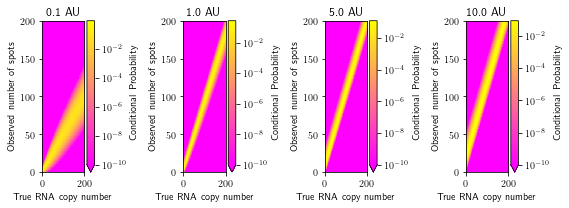

In [11]:
with np.load("results/smfish_probe_distortions.npz", allow_pickle=True) as _:
    probeLevels = _["levels"]
    probe_pdos = _["pdos"][()]

numPdos = len(probe_pdos)
fig, axs = plt.subplots(1, numPdos)
fig.set_size_inches(2*numPdos, 3)
fig.set_tight_layout(True)
for i in range(numPdos):
    heatmap = axs[i].pcolorfast(np.maximum(probe_pdos[probeLevels[i]], 1.0e-16),
                                cmap=plt.cm.get_cmap("spring"),
                                norm=Colors.LogNorm(vmin=1.0E-10))
    axs[i].set_ylim([0, 200])
    axs[i].set_xlim([0, 200])
    fig.colorbar(heatmap,  ax=axs[i], orientation='vertical', extend='min', label=r"Conditional Probability")
    axs[i].set_title(f"{probeLevels[i]} AU")
    axs[i].set_xlabel("True RNA copy number")
    axs[i].set_ylabel("Observed number of spots")
fig.savefig("figs/probe_binding_pdos.png", dpi=300, bbox_inches="tight")

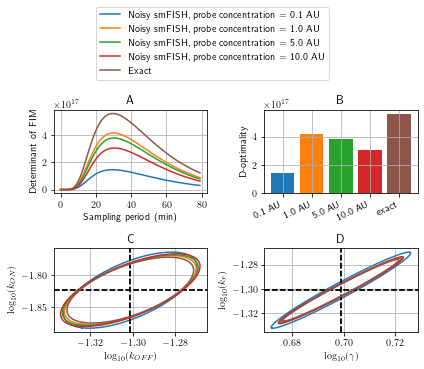

In [12]:
with np.load("results/fim_probe_binding.npz", allow_pickle=True) as _:
    fims_probe = _["fim_multi_cells_times"][()]
    dets_probe = _["det_fim_multi_cells_times"][()]
    optdt_probe = _["opt_dts"][()]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(6, 4)
fig.set_tight_layout(True)
cm = plt.cm.get_cmap("tab10")
for i, level in enumerate(probeLevels):
    color = cm(i)#cm(level/max(probeLevels))
    axs[0, 0].plot(dets_probe[level], color=color, label=f"Noisy smFISH, probe concentration = {level} AU")
    axs[0, 1].bar(i, dets_probe[level][optdt_probe[level]], color=color)
    plotConfidenceEllipse(fim=fims_probe[level][optdt_probe[level]], num_sigma=3, color=color, ax=axs[1, 0], theta=np.log10(theta), par_idx=[0, 1])
    plotConfidenceEllipse(fim=fims_probe[level][optdt_probe[level]], num_sigma=3, color=color, ax=axs[1, 1], theta=np.log10(theta), par_idx=[2, 3])

axs[0, 0].plot(det_fim_multi_cells_times['exact'], color=cm(5), label="Exact")
axs[0, 1].bar(4, det_fim_multi_cells_times['exact'][opt_rates["exact"]], color=cm(5))
plotConfidenceEllipse(fim=fim_multi_cells_times["exact"][opt_rates["exact"]], num_sigma=3, color=cm(5), ax=axs[1, 0], theta=np.log10(theta), par_idx=[0, 1])
plotConfidenceEllipse(fim=fim_multi_cells_times["exact"][opt_rates["exact"]], num_sigma=3, color=cm(5), ax=axs[1, 1], theta=np.log10(theta), par_idx=[2, 3])

axs[0, 0].set_xlabel("Sampling period (min)")
axs[0, 0].set_ylabel("Determinant of FIM")
axs[0, 1].set_ylabel("D-optimality")
axs[0, 1].set_xticks(range(5))
axs[0, 1].set_xticklabels([f"{level} AU" for level in probeLevels] + ["exact"], rotation=25, ha='right')

axs[1, 0].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1, 0].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[1, 1].set_ylabel('$\log_{10}({k_{r}})$')
axs[1, 1].set_xlabel('$\log_{10}({\gamma})$')

for ax in axs.flatten():
    ax.grid(True)

h, l = axs[0, 0].get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0, 1, 1, 1))
labelAxes(axs)

fig.savefig("figs/bursting_probe_cme.png", dpi=300, bbox_inches="tight")

## MLE validations for the cell image mis-segmentation noise in SI

In [13]:
fim = fim_multi_cells_times["binomial_state_dep"][30]
fim_cov = np.linalg.inv(fim)
print(sample_cov_correct)
print(np.linalg.inv(fim))
print(np.linalg.norm(sample_cov_correct - fim_cov, "fro")/np.linalg.norm(fim_cov, "fro"))

[[ 1.04929896e-04  1.24916328e-04  2.29491178e-05  2.09058069e-05]
 [ 1.24916328e-04  4.65260332e-04  2.55888839e-05 -1.72808380e-05]
 [ 2.29491178e-05  2.55888839e-05  7.63687117e-05  8.78405176e-05]
 [ 2.09058069e-05 -1.72808380e-05  8.78405176e-05  1.13055815e-04]]
[[ 1.08289335e-04  1.32518927e-04  2.45446776e-05  2.23726953e-05]
 [ 1.32518927e-04  4.66644079e-04  2.55177344e-05 -1.74716170e-05]
 [ 2.45446776e-05  2.55177344e-05  1.06816080e-04  1.24207493e-04]
 [ 2.23726953e-05 -1.74716170e-05  1.24207493e-04  1.56396396e-04]]
0.1290765980673248


In [14]:
with np.load("results/double_cell_fims.npz", allow_pickle=True) as _:
    cell_merging_rates = _["error_rates"]
    cell_merging_fims = _["fim_analyses"][()]

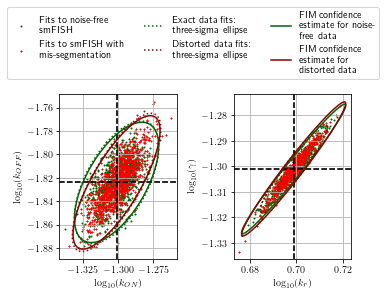

In [15]:
from textwrap import fill

with np.load("results/double_cell_mle_fits.npz") as _:
    exact_data_fits = _["exact_data_fits"]
    distorted_data_fits = _["distorted_data_fits"]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(5,3)
fig.set_tight_layout(True)

exact_fits_cov = np.cov(exact_data_fits, rowvar=False)
distorted_fits_cov = np.cov(distorted_data_fits, rowvar=False)
for i, pair in enumerate([[0, 1], [2, 3]]):
    axs[i].grid(True)
    #
    axs[i].scatter(exact_data_fits[:, pair[0]], exact_data_fits[:, pair[1]], 1, color="darkgreen", label="Fits to noise-free smFISH")
    axs[i].scatter(distorted_data_fits[:, pair[0]], distorted_data_fits[:, pair[1]], 1, color="red", label="Fits to smFISH with mis-segmentation", marker="x")

    plotConfidenceEllipse(np.linalg.inv(exact_fits_cov),
                  3,
                  axs[i],
                  [pair[0],pair[1]],
                  np.log10(theta),
                  "darkgreen", 'Exact data fits: three-sigma ellipse', ':')

    plotConfidenceEllipse(np.linalg.inv(distorted_fits_cov),
                  3,
                  axs[i],
                  [pair[0],pair[1]],
                  np.log10(theta),
                  "darkred", 'Distorted data fits: three-sigma ellipse', ':')

    plotConfidenceEllipse(fim_multi_cells_times["exact"][30],
                          3,
                          axs[i],
                          [pair[0],pair[1]],
                          np.log10(theta),
                          "darkgreen",
                          "FIM confidence estimate for noise-free data")

    plotConfidenceEllipse(cell_merging_fims[1.0]["fims_experiment"][30],
                          3,
                          axs[i],
                          [pair[0],pair[1]],
                          np.log10(theta),
                          "darkred",
                          "FIM confidence estimate for distorted data")



axs[0].set_xlabel('$\log_{10}({k_{ON}})$')
axs[0].set_ylabel('$\log_{10}({k_{OFF}})$')
axs[1].set_xlabel('$\log_{10}({k_{r}})$')
axs[1].set_ylabel('$\log_{10}({\gamma})$')


h, labels = axs[0].get_legend_handles_labels()
labels = [fill(label, 20) for label in labels]
fig.legend(h, labels, bbox_to_anchor=(0, 1, 0, 0), loc="lower left", ncol=3)
fig.savefig("figs/bursting_missegmentation_mle.png", dpi=300, bbox_inches="tight")

AttributeError: 'AxesSubplot' object has no attribute 'yticklabel'

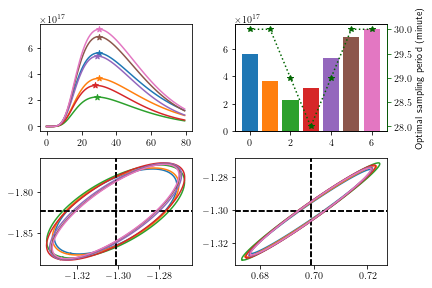

In [30]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(6, 4)
fig.set_tight_layout(True)
cm = plt.cm.get_cmap("tab10")

for i, rate in enumerate(cell_merging_rates):
    color = cm(i)#cm(level/max(probeLevels))

    dets = cell_merging_fims[rate]["fims_dets_experiment"]
    dt_opt = cell_merging_fims[rate]["dt_opt"]
    fims = cell_merging_fims[rate]["fims_experiment"]


    axs[0, 0].plot(dets, color=color, label=rf"$\rho$ = {rate}")
    axs[0, 0].scatter(dt_opt, dets[dt_opt], color=color, marker="*")

    axs[0, 1].bar(i, dets[dt_opt], color=color)

    plotConfidenceEllipse(fim=fims[dt_opt], num_sigma=3, color=color, ax=axs[1, 0], theta=np.log10(theta), par_idx=[0, 1])
    plotConfidenceEllipse(fim=fims[dt_opt], num_sigma=3, color=color, ax=axs[1, 1], theta=np.log10(theta), par_idx=[2, 3])

axs01twin = axs[0, 1].twinx()
axs01twin.plot(range(0,len(cell_merging_rates)), [cell_merging_fims[rate]["dt_opt"] for rate in cell_merging_rates], marker="*", ls=":", color="darkgreen")
axs01twin.set_ylabel("Optimal sampling period (minute)")
axs01twin.spines["right"].set_color("darkgreen")
axs01twin.tick_params(axis="y", color="darkgreen")

axs[0, 0].set_xlabel("Sampling period (minute)")
axs[0, 0].set_ylabel("Determinant of FIM")
axs[0, 1].set_ylabel("D-optimality")
axs[0, 1].set_xticks(range(len(cell_merging_rates)))
axs[0, 1].set_xticklabels(cell_merging_rates, rotation=25, ha='right')
axs[0, 1].set_xlabel(r"$\rho$")

axs[1, 0].set_ylabel('$\log_{10}({k_{ON}})$')
axs[1, 0].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[1, 1].set_ylabel('$\log_{10}({k_{r}})$')
axs[1, 1].set_xlabel('$\log_{10}({\gamma})$')

for ax in axs.flatten():
    ax.grid(True)

h, l = axs[0, 0].get_legend_handles_labels()
fig.legend(h, l, loc="lower center", bbox_to_anchor=(0, 1, 1, 1), ncol=4)
labelAxes(axs)

fig.savefig("figs/bursting_missegmentation_fims.png", dpi=300, bbox_inches="tight")